In [1]:
# carico i modelli dalla mia repository

def get_dbn_library():
  files = ["DBN.py"]
  repository_url = "https://raw.githubusercontent.com/LorenzoTausani/Octave_CPU/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

get_dbn_library()

import DBN

from torchvision import datasets,transforms
import torch
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np
from matplotlib import cm
import math
import random


from DBN import DBN

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {DEVICE}")

--2022-07-06 23:04:34--  https://raw.githubusercontent.com/LorenzoTausani/Octave_CPU/master/DBN.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19769 (19K) [text/plain]
Saving to: ‘DBN.py’

DBN.py              100%[===================>]  19.31K  --.-KB/s    in 0s      

2022-07-06 23:04:35 (126 MB/s) - ‘DBN.py’ saved [19769/19769]

Using device cuda


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


The number shown is the number: 8


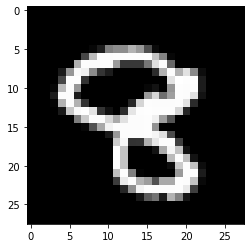

In [2]:
#Loading MNIST dataset
mnist_data_train = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose(
                    [transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))

mnist_data_test = datasets.MNIST('../data', train=False, download=True,
                    transform=transforms.Compose(
                    [transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))


mnist_data_train.data = (mnist_data_train.data.type(torch.FloatTensor)/255)
mnist_data_test.data = (mnist_data_test.data.type(torch.FloatTensor)/255)

#https://stackoverflow.com/questions/68056122/attributeerror-cant-set-attribute-in-splitting-mnist-dataset


#Lets us visualize a number from the data set
idx = 787
img = mnist_data_test.data[idx]
print("The number shown is the number: {}".format(mnist_data_test.train_labels[idx]) )
plt.imshow(img , cmap = 'gray')
plt.show()

train_data = mnist_data_train.data.to(DEVICE)
train_labels = mnist_data_train.train_labels.to(DEVICE)

test_data = mnist_data_test.data.to(DEVICE)
test_labels = mnist_data_test.train_labels.to(DEVICE)

#modificare solo se necessario
sample_test_data = test_data[:1000,:] 
sample_test_labels = test_labels[:1000]

In [3]:
def model_load_or_create(train_data, train_labels, sample_test_data, sample_test_labels):
  Load_yn=int(input('do you want to load an old model? (1=yes, 0=no)'))

  if Load_yn==1:
    nr_train_epochs_done=int(input('quante epoche di training della RBM?'))
    #h_train_size = int(input('quanti h train generati (0 se nessuno)?'))
    #h_test_size = int(input('quanti h test generati (0 se nessuno)?'))
    #nr_steps = int(input('con quanti step di ricostruzione?'))

    h_train_size = len(train_labels)
    h_test_size = len(sample_test_labels)
    nr_steps = 100

    filename = 'OctaveCPU_RBM'+ str(nr_train_epochs_done)+'_generated_h_train'+str(h_train_size)+'_generated_h_test'+str(h_test_size)+'nr_steps'+str(nr_steps)

    model = load_model(filename)

  else:
    num_epochs = int(input('trainare la rete? quante epoche? (0 se non si vuole trainare'))

    model = DBN(maxepochs   = num_epochs ,device=DEVICE)    
    model.train(train_data,train_labels)

  dati_generati_yn = int(input('creare nuovi dati generati (0=no, 1=train, 2=test, 3= entrambi)'))

  if dati_generati_yn ==1 or dati_generati_yn ==3:
    nr_steps = 1
    model.reconstruct(train_data,nr_steps,new_test1_train2_set = 2,lbl_train=train_labels, include_energy =0)

  if dati_generati_yn ==2 or dati_generati_yn ==3:
    print('jodel')
    nr_steps = 100
    model.reconstruct(sample_test_data,nr_steps,new_test1_train2_set = 1,lbl_test=sample_test_labels)

  if not(hasattr(model, 'Cl_TEST_step_accuracy')):
    model.stepwise_Cl_accuracy()

  save_yn = int(input('salvare il modello? (0=no, 1=si)'))

  if save_yn ==1:
    model.save_model()

  return model  

def load_model(filename):

    filename = '/content/gdrive/My Drive/' + filename + '/' + filename + '.pkl'

    from google.colab import drive
    drive.mount('/content/gdrive')

    with open(filename, 'rb') as inp:
        model = pickle.load(inp)

    return model  


def mean_h_prior(model):
  mean_h_prob_mat = torch.zeros(model.Num_classes+1,model.layersize[0]).to(model.DEVICE)
  gen_H = model.TRAIN_gen_hid_prob[:,:,0]

  for it in range(model.Num_classes+1):
    if it>9:
      mean_h_prob_mat[it,:] = torch.mean(gen_H,0)
    else:
      l = torch.where(model.TRAIN_lbls == it)
      gen_H_digit = gen_H[l[0],:]
      mean_h_prob_mat[it,:] = torch.mean(gen_H_digit,0)

  mean_h_prob_mat=torch.unsqueeze(mean_h_prob_mat,2)
  return mean_h_prob_mat


In [4]:
from operator import index
dim_scritte = 50
lin_sz = 5

def Between_model_Cl_accuracy(models_list, nr_steps, dS = dim_scritte, l_sz = lin_sz):

  figure, axis = plt.subplots(1, 1, figsize=(15,15))

  lbls = []
  x = range(1,nr_steps+1)


  c=30
  cmap = cm.get_cmap('hsv')
  for model in models_list:
    axis.plot(x,model.Cl_TEST_step_accuracy[:nr_steps], linewidth=l_sz, markersize=12,marker='o', c=cmap(c/256))
    c = c+30
    lbls.append(model.maxepochs)

  axis.tick_params(axis='x', labelsize= dS)
  axis.tick_params(axis='y', labelsize= dS)

  axis.legend(lbls, bbox_to_anchor=(1.04,1), loc="upper left", fontsize=dS) #cambia posizione
  axis.set_ylabel('Linear classifier accuracy',fontsize=dS)
  axis.set_xlabel('Nr. reconstruction steps',fontsize=dS)
  axis.set_title('Classifier accuracy',fontsize=dS)

  #axis.set_xticks(np.arange(0, nr_steps+1, 1))
  axis.set_yticks(np.arange(0, 1.1, 0.1))


  plt.show()

def Reconstuct_plot(mnist_data_test,model,nr_steps, temperature = 1, row_step = 10):

  rows = math.floor(nr_steps/row_step)

  figure, axis = plt.subplots(rows+1, 10, figsize=(25,2.5*(1+rows)))
  

  for lbl in range(10):

      idx = int(torch.where(mnist_data_test.test_labels == lbl)[0][0])
      img = mnist_data_test.data[idx:idx+1]
      d= model.reconstruct(img.to(DEVICE),nr_steps, temperature=temperature)
      reconstructed_imgs=d['vis_states']

      axis[0, lbl].imshow(torch.squeeze(img) , cmap = 'gray')
      axis[0, lbl].set_title("Original number:{}".format(lbl))

      axis[0, lbl].set_xticklabels([])
      axis[0, lbl].set_yticklabels([])
      axis[0, lbl].set_aspect('equal')

      
      for idx,step in enumerate(range(row_step,nr_steps+1,row_step)):
        idx = idx+1

        reconstructed_img= reconstructed_imgs[:,:,step-1]
        reconstructed_img = reconstructed_img.view((28,28)).cpu()

        axis[idx, lbl].imshow(reconstructed_img , cmap = 'gray')
        axis[idx, lbl].set_title("Rec.-step {}".format(step))

        axis[idx, lbl].set_xticklabels([])
        axis[idx, lbl].set_yticklabels([])
        axis[idx, lbl].set_aspect('equal')



      #plt.subplots_adjust(hspace=0)
  plt.subplots_adjust(left=0.1, 
                      bottom=0.1,  
                      right=0.9,  
                      top=0.9,  
                      wspace=0.4,  
                      hspace=0) 
  
  #plt.savefig("Reconstuct_plot.jpg")

  plt.show()

def Reconstuct_from_hidden_plot(input_hidden, nr_steps, temperature = 1, row_step = 10):
  # with mean prior : mean_h_prior(model) as input_hidden

  rows = math.floor(nr_steps/row_step)

  figure, axis = plt.subplots(rows+1, input_hidden.size()[0], figsize=(25,2.5*(1+rows)))

  d= model.reconstruct_from_hidden(input_hidden , nr_steps, temperature=temperature)
  reconstructed_all=d['vis_states']
  
  for lbl in range(input_hidden.size()[0]):
      reconstructed_imgs = reconstructed_all[lbl:lbl+1,:,:]

      for idx,step in enumerate(range(0,nr_steps+1,row_step)):
        if step==0:
           step=1

        reconstructed_img= reconstructed_imgs[:,:,step-1]
        reconstructed_img = reconstructed_img.view((28,28)).cpu()

        axis[idx,lbl].imshow(reconstructed_img , cmap = 'gray')
        axis[idx,lbl].set_title("Rec.-step {}".format(step))

        axis[idx,lbl].set_xticklabels([])
        axis[idx,lbl].set_yticklabels([])
        axis[idx,lbl].set_aspect('equal')


  #plt.subplots_adjust(hspace=0)
  plt.subplots_adjust(left=0.1, 
                      bottom=0.1,  
                      right=0.9,  
                      top=0.9,  
                      wspace=0.4,  
                      hspace=0) 
  
  #plt.savefig("Reconstuct_plot.jpg")

  plt.show()  
 

  
def Digitwise_cosine_similarity_plot(model,sample_test_data,  dS = dim_scritte, l_sz = lin_sz):

  c=0
  cmap = cm.get_cmap('hsv')
  figure, axis = plt.subplots(1, 1, figsize=(15,15))
  lbls = []
  for digit in range(10):
      l = torch.where(model.TEST_lbls == digit)
      original_data = sample_test_data[l[0],:,:]
      generated_data = model.TEST_vis_states[l[0],:,:]
      model.cosine_similarity(original_data, generated_data, Plot=1, Color = cmap(c/256), Linewidth=l_sz)
      c = c+25
      lbls.append(digit)
     
  axis.legend(lbls, bbox_to_anchor=(1.04,1), loc="upper left", fontsize=dS) #cambia posizione
  axis.tick_params(axis='x', labelsize= dS)
  axis.tick_params(axis='y', labelsize= dS)
  axis.set_ylabel('Cosine similarity',fontsize=dS)
  axis.set_xlabel('Nr. reconstruction steps',fontsize=dS)
  axis.set_title('Cosine similarity - digitwise',fontsize=dS)

  plt.show()


def Average_cosine_similarity_plot(model,sample_test_data,  dS = dim_scritte, l_sz = lin_sz):

  figure, axis = plt.subplots(1, 1, figsize=(15,15))

  model.cosine_similarity(sample_test_data, model.TEST_vis_states, Plot=1, Color = 'blue',Linewidth=l_sz)
     
  axis.tick_params(axis='x', labelsize= dS)
  axis.tick_params(axis='y', labelsize= dS)
  axis.set_ylabel('Cosine similarity',fontsize=dS)
  axis.set_xlabel('Nr. reconstruction steps',fontsize=dS)
  axis.set_title('Average cosine similarity',fontsize=dS)

  plt.show()


def Digitwise_energy_plot(model,  dS = dim_scritte, l_sz = lin_sz):

  c=0
  cmap = cm.get_cmap('hsv')
  figure, axis = plt.subplots(1, 1, figsize=(15,15))
  lbls = []
  for digit in range(10):
      Color = cmap(c/256) 
      l = torch.where(model.TEST_lbls == digit)
      energy_mat_digit = model.TEST_energy_matrix[l[0],:]
      nr_steps = energy_mat_digit.size()[1]
      SEM = torch.std(energy_mat_digit,0)/math.sqrt(nr_steps)
      SEM = SEM.cpu()
      MEAN = torch.mean(energy_mat_digit,0).cpu()
      x = range(1,nr_steps+1)
      plt.plot(x, MEAN, c = Color, linewidth=l_sz)
      plt.fill_between(x,MEAN-SEM, MEAN+SEM, color=Color,
                      alpha=0.3)
      c = c+25
      lbls.append(digit)
     
  axis.legend(lbls, bbox_to_anchor=(1.04,1), loc="upper left", fontsize=dS) #cambia posizione
  axis.tick_params(axis='x', labelsize= dS)
  axis.tick_params(axis='y', labelsize= dS)
  axis.set_ylabel('Energy',fontsize=dS)
  axis.set_xlabel('Nr. reconstruction steps',fontsize=dS)
  axis.set_title('Energy - digitwise',fontsize=dS)

  plt.show()

def Average_energy_plot(model,  dS = dim_scritte, l_sz = lin_sz):
  Color = 'lime'

  figure, axis = plt.subplots(1, 1, figsize=(15,15))

  energy_mat_digit = model.TEST_energy_matrix
  nr_steps = energy_mat_digit.size()[1]
  SEM = torch.std(energy_mat_digit,0)/math.sqrt(nr_steps)
  SEM = SEM.cpu()
  MEAN = torch.mean(energy_mat_digit,0).cpu()
  x = range(1,nr_steps+1)
  plt.plot(x, MEAN, c = Color, linewidth=l_sz)
  plt.fill_between(x,MEAN-SEM, MEAN+SEM, color=Color,
                  alpha=0.3)
     
  axis.tick_params(axis='x', labelsize= dS)
  axis.tick_params(axis='y', labelsize= dS)
  axis.set_ylabel('Energy',fontsize=dS)
  axis.set_xlabel('Nr. reconstruction steps',fontsize=dS)
  axis.set_title('Average energy',fontsize=dS)

  plt.show()


def Average_perc_act_H_plot(model,  dS = dim_scritte, l_sz = lin_sz):
  Color = 'black'
  figure, axis = plt.subplots(1, 1, figsize=(15,15))

  gen_H = model.TEST_gen_hid_states
  nr_steps = gen_H.size()[2]

  mean_h1_step = torch.mean(torch.mean(gen_H,1)*100,0).cpu()
  sem_h1_step = (torch.std(torch.mean(gen_H,1)*100,0)/math.sqrt(nr_steps)).cpu()
  x = range(1,nr_steps+1)
  plt.plot(x, mean_h1_step, c = Color, linewidth=l_sz)
  plt.fill_between(x,mean_h1_step-sem_h1_step, mean_h1_step+sem_h1_step, color=Color,
                  alpha=0.3)
     
  axis.tick_params(axis='x', labelsize= dS)
  axis.tick_params(axis='y', labelsize= dS)
  axis.set_ylabel('% of active hidden units',fontsize=dS)
  axis.set_xlabel('Nr. reconstruction steps',fontsize=dS)
  axis.set_title('Average active hidden units',fontsize=dS)

  plt.show()

def Average_actnorm_plot(model,  dS = dim_scritte, l_sz = lin_sz):
  Color = 'black'
  figure, axis = plt.subplots(1, 1, figsize=(15,15))

  gen_H = model.TEST_gen_hid_prob
  nr_steps = gen_H.size()[2]

  act_norm = gen_H.pow(2).sum(dim=1).sqrt()

  mean_h1_step = torch.mean(act_norm,0).cpu()
  sem_h1_step = (torch.std(act_norm,0)/math.sqrt(nr_steps)).cpu() #sqrt non è del nr steps credo
  x = range(1,nr_steps+1)
  plt.plot(x, mean_h1_step, c = Color, linewidth=l_sz)
  plt.fill_between(x,mean_h1_step-sem_h1_step, mean_h1_step+sem_h1_step, color=Color,
                  alpha=0.3)
     
  axis.tick_params(axis='x', labelsize= dS)
  axis.tick_params(axis='y', labelsize= dS)
  axis.set_ylabel('activation norm (L2 norm)',fontsize=dS)
  axis.set_xlabel('Nr. reconstruction steps',fontsize=dS)
  axis.set_title('Average activation norm - hid_prob',fontsize=dS)

  plt.show()




def Digitwise_perc_act_H_plot(model,  dS = dim_scritte, l_sz = lin_sz):
  c=0
  cmap = cm.get_cmap('hsv')
  figure, axis = plt.subplots(1, 1, figsize=(15,15))
  lbls = []
  for digit in range(10):
      Color = cmap(c/256) 
      l = torch.where(model.TEST_lbls == digit)
      gen_H_digit = model.TEST_gen_hid_states[l[0],:,:]
      nr_steps = gen_H_digit.size()[2]
      SEM = torch.std(torch.mean(gen_H_digit,1)*100,0)/math.sqrt(nr_steps)
      SEM = SEM.cpu()
      MEAN = torch.mean(torch.mean(gen_H_digit,1)*100,0).cpu()
      x = range(1,nr_steps+1)
      plt.plot(x, MEAN, c = Color, linewidth=l_sz)
      plt.fill_between(x,MEAN-SEM, MEAN+SEM, color=Color,
                      alpha=0.3)
      c = c+25
      lbls.append(digit)
     
  axis.legend(lbls, bbox_to_anchor=(1.04,1), loc="upper left", fontsize=dS) #cambia posizione
     
  axis.tick_params(axis='x', labelsize= dS)
  axis.tick_params(axis='y', labelsize= dS)
  axis.set_ylabel('% of active hidden units',fontsize=dS)
  axis.set_xlabel('Nr. reconstruction steps',fontsize=dS)
  axis.set_title('Active hidden units - digitwise',fontsize=dS)

  plt.show()

def Digitwise_actnorm_plot(model,  dS = dim_scritte, l_sz = lin_sz):
  c=0
  cmap = cm.get_cmap('hsv')
  figure, axis = plt.subplots(1, 1, figsize=(15,15))
  lbls = []
  for digit in range(10):
      Color = cmap(c/256) 
      l = torch.where(model.TEST_lbls == digit)
      gen_H_digit = model.TEST_gen_hid_prob[l[0],:,:]
      act_norm = gen_H_digit.pow(2).sum(dim=1).sqrt()
      nr_steps = gen_H_digit.size()[2]
      SEM = torch.std(act_norm,0)/math.sqrt(nr_steps)
      SEM = SEM.cpu()
      MEAN = torch.mean(act_norm,0).cpu()
      x = range(1,nr_steps+1)
      plt.plot(x, MEAN, c = Color, linewidth=l_sz)
      plt.fill_between(x,MEAN-SEM, MEAN+SEM, color=Color,
                      alpha=0.3)
      c = c+25
      lbls.append(digit)
     
  axis.legend(lbls, bbox_to_anchor=(1.04,1), loc="upper left", fontsize=dS) #cambia posizione
     
  axis.tick_params(axis='x', labelsize= dS)
  axis.tick_params(axis='y', labelsize= dS)
  axis.set_ylabel('activation norm (L2 norm)',fontsize=dS)
  axis.set_xlabel('Nr. reconstruction steps',fontsize=dS)
  axis.set_title('Digitwise activation norm - hid_prob',fontsize=dS)

  plt.show()



def Cosine_hidden_plot(model,  dS = 20, l_sz = lin_sz):
  S1_pHid = model.TEST_gen_hid_prob[:,:,0]
  cmap = cm.get_cmap('hsv')
  figure, axis = plt.subplots(1, 10, figsize=(50,5))
  lbls = range(10)
  ref_mat = torch.zeros([10,1000], device =model.DEVICE)

  for digit in range(10):
      
      l = torch.where(model.TEST_lbls == digit)
      Hpr_digit = S1_pHid[l[0],:]
      ref_mat[digit,:] = torch.mean(Hpr_digit,0)
  
  for digit_plot in range(10):
      c=0
      l = torch.where(model.TEST_lbls == digit_plot)
      Hpr_digit = model.TEST_gen_hid_prob[l[0],:,:]
      for digit in range(10):
          model.cosine_similarity(ref_mat[digit:digit+1,:], Hpr_digit, Plot=1, Color = cmap(c/256), Linewidth=l_sz, axis=axis[digit_plot])
          c = c+25
      if digit_plot==9:
        axis[digit_plot].legend(lbls, bbox_to_anchor=(1.04,1), loc="upper left", fontsize=dS) #cambia posizione
      axis[digit_plot].tick_params(axis='x', labelsize= dS)
      axis[digit_plot].tick_params(axis='y', labelsize= dS)
      axis[digit_plot].set_ylabel('Cosine similarity',fontsize=dS)
      axis[digit_plot].set_xlabel('Nr. reconstruction steps',fontsize=dS)
      axis[digit_plot].set_title("Digit: {}".format(digit_plot),fontsize=dS)  

        #da finire 05 07
  plt.subplots_adjust(left=0.1, 
                      bottom=0.1,  
                      right=0.9,  
                      top=0.9,  
                      wspace=0.4,  
                      hspace=0) 


In [6]:
#nr_models_to_compare = int(input('how many models do you want to compare?'))
nr_models_to_compare = 1
models_list =[]

for i in range(nr_models_to_compare):
  model = model_load_or_create(train_data, train_labels, sample_test_data, sample_test_labels)
  models_list.append(model)
  
  

do you want to load an old model? (1=yes, 0=no)1
quante epoche di training della RBM?100
Mounted at /content/gdrive
creare nuovi dati generati (0=no, 1=train, 2=test, 3= entrambi)0
salvare il modello? (0=no, 1=si)0


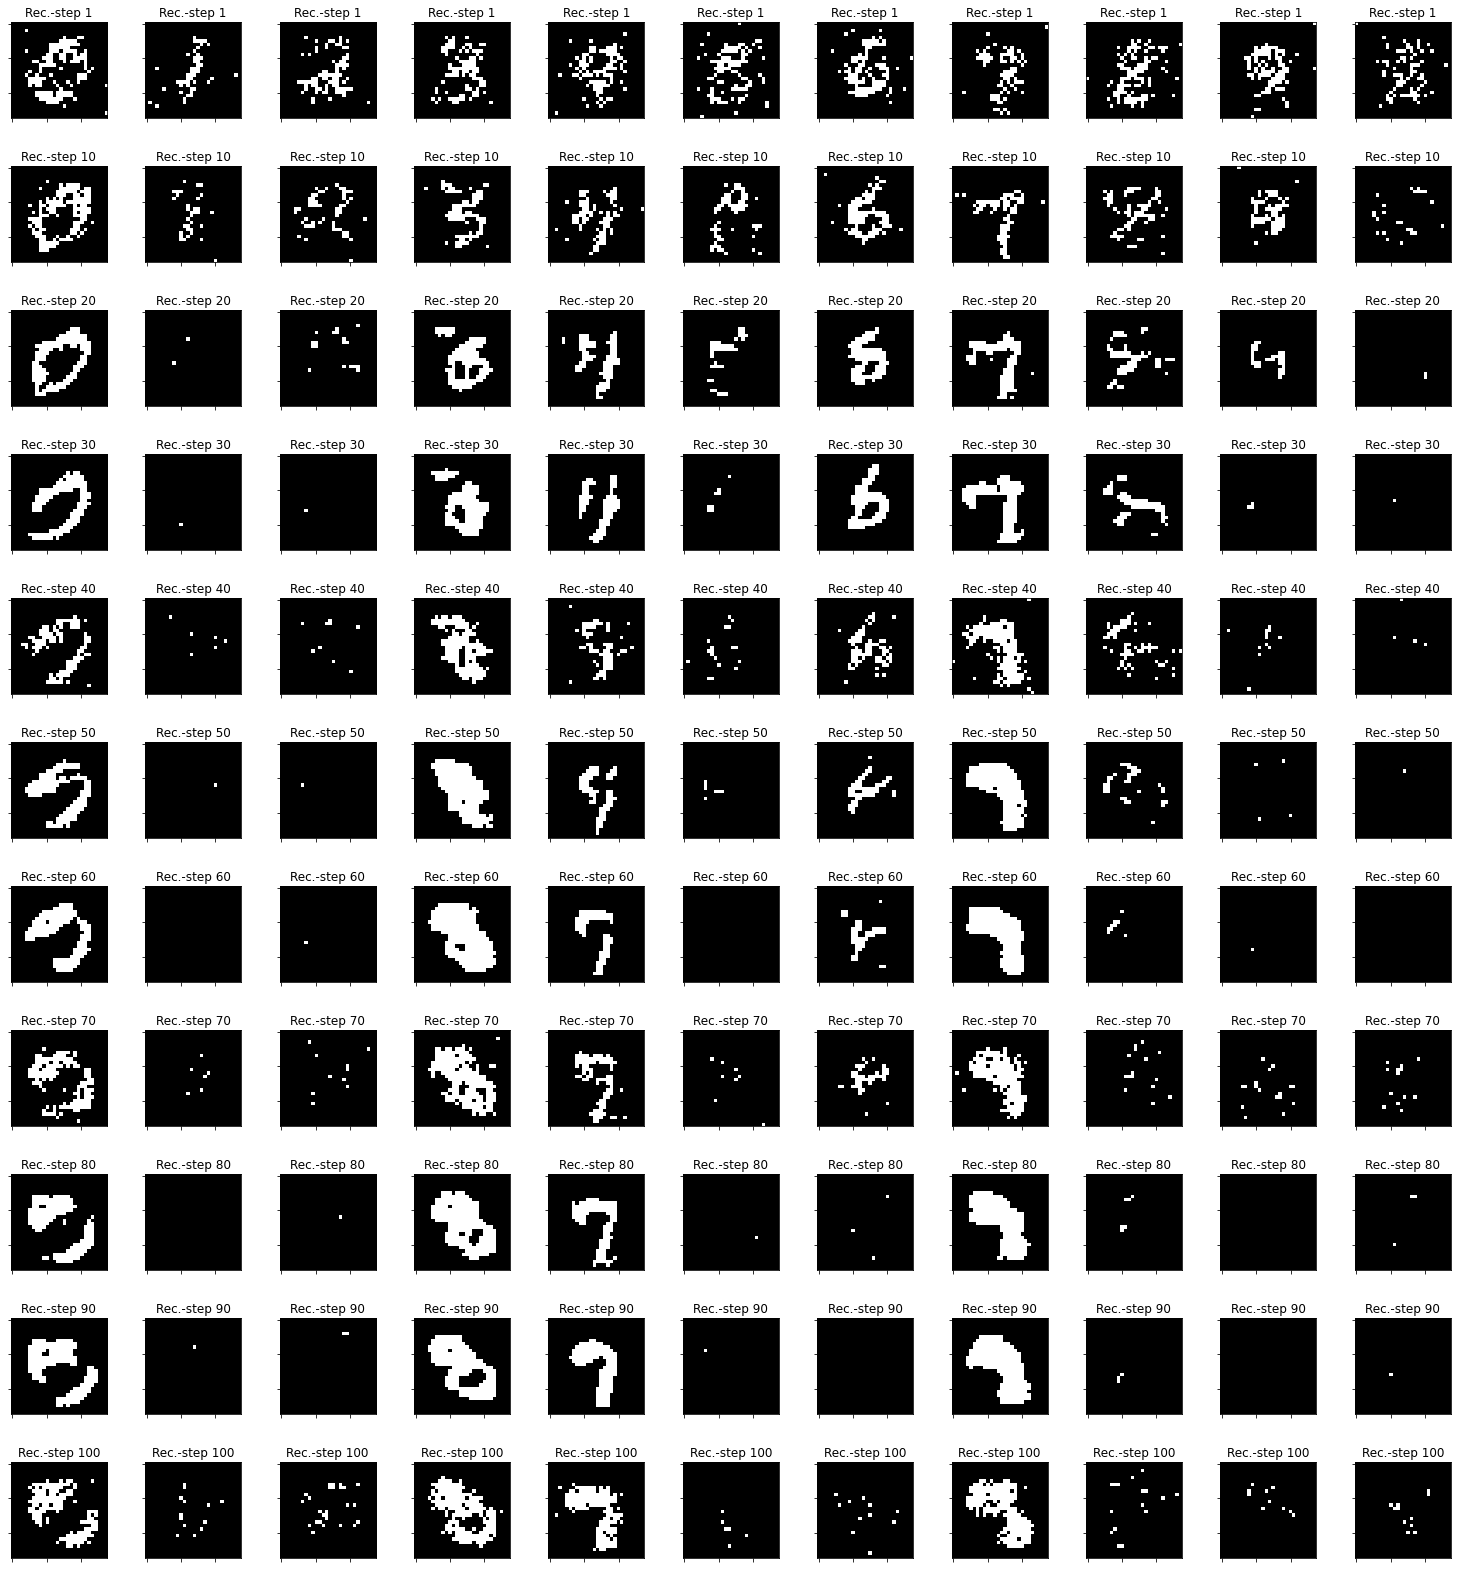

In [11]:
Reconstuct_from_hidden_plot(mean_h_prior(model), 100, temperature = [2,0.5,0.5], row_step = 10)